# Exploring Accessory Dwelling Unit Development in San Francisco

## General Data Exploration

In [61]:
echo: True 
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import geopandas as gpd
import hvplot.pandas
import holoviews as hv
from holoviews import streams
import panel as pn
import rasterio as rio
from rasterio.features import geometry_mask
from shapely.geometry import mapping
from rasterio.io import MemoryFile
from shapely.geometry import box, mapping
from fiona.crs import from_epsg
from rasterio.mask import mask
from rasterstats import zonal_stats
import contextily as ctx
from shapely.geometry import Point, Polygon
import folium
import geoviews as gv
import geoviews.tile_sources as gvts
from folium.plugins import MarkerCluster
from ipywidgets import interact, widgets
import xyzservices
from folium import plugins
from branca.colormap import linear

In [62]:
echo: True 
#Bring in data on ADU permits
permits = pd.read_csv("Building_Permits.csv")

In [63]:
echo: True 
#Extract year from Filed Date
permits['Filed Date'] = pd.to_datetime(permits['Filed Date'])

permits['year'] = permits['Filed Date'].dt.year

In [64]:
echo: True 
#Counts of permits per year
year_counts = permits['year'].value_counts()

### Number of ADU Permits Issued Per Year
This simple bar chart shows that after a boom in ADU development between 2013 and 2020, the number of permits per year have steadily declined.

Note: The 2023 data only reflects permits through November.

Text(0.5, 1.0, 'ADU Permits by Year')

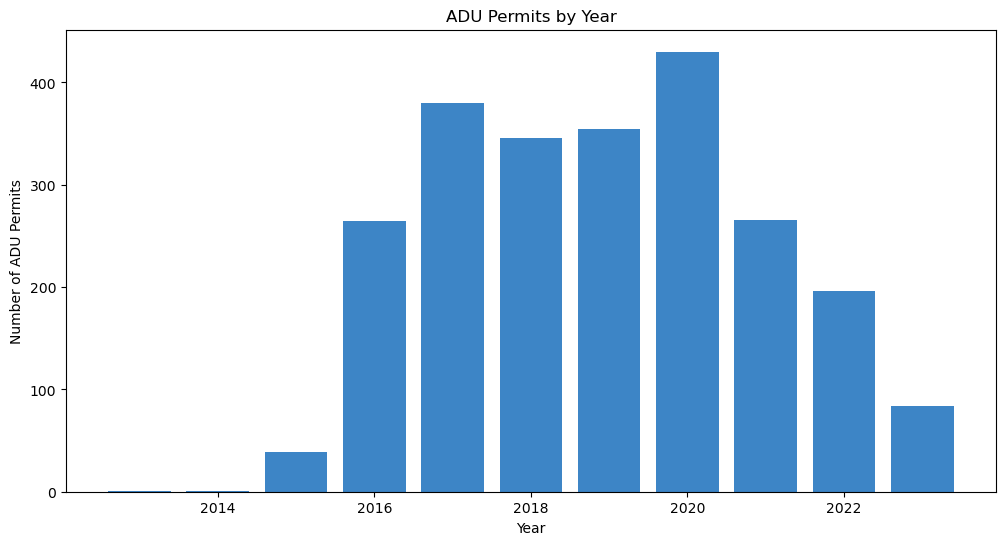

In [65]:
echo: True 
#Making bar chart for permits per year
plt.figure(figsize=(12, 6))
plt.bar(year_counts.index, year_counts.values, color='#3d85c6ff')
plt.xlabel('Year')
plt.ylabel('Number of ADU Permits')
plt.title('ADU Permits by Year')

In [66]:
echo: True 
#New variable for net new units
permits['new units'] = permits['Proposed Units'] - permits['Existing Units']

In [67]:
echo: True 
#Sum of units per year
units_by_year = permits.groupby('year')['new units'].sum().reset_index()

### Number of ADU Units Permitted Per Year
It's important to note that a single permit could be issued for multiple ADU units. This chart shows the number of actual units approved per year.

While a bit more useful than the previous chart, it largely tells the same story.

Text(0.5, 1.0, 'ADU Units by Year')

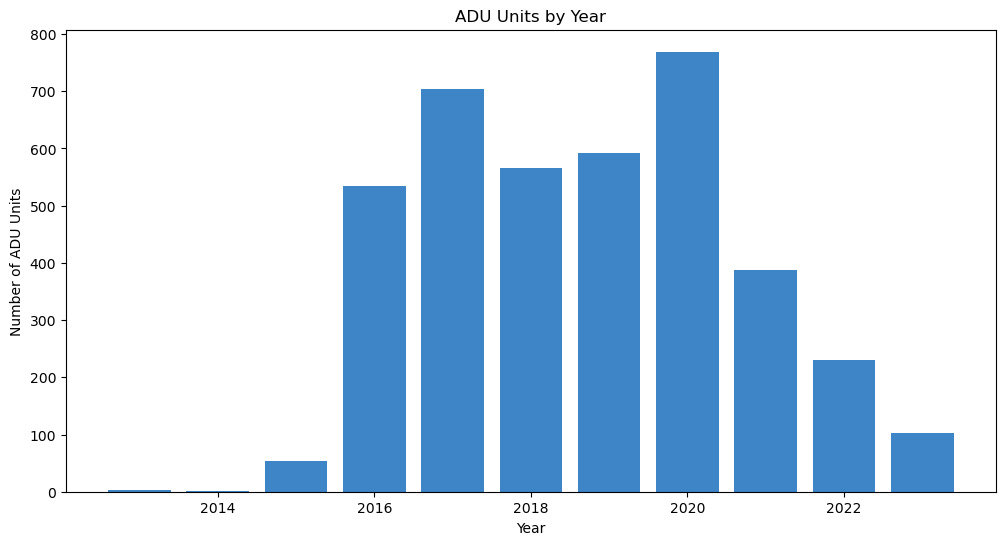

In [68]:
echo: True 
#Making bar chart for units per year
plt.figure(figsize=(12, 6))
plt.bar(units_by_year['year'], units_by_year['new units'], color='#3d85c6ff')
plt.xlabel('Year')
plt.ylabel('Number of ADU Units')
plt.title('ADU Units by Year')

In [69]:
echo: True 
#Counts of permits by number of units
permits = permits.dropna(subset=['new units'])
unit_counts = permits['new units'].value_counts()

### Number of Permits by Number of Proposed ADU Units
How common is it for one permit to propose multiple ADU units? This chart shows that while it is most common for ADU permits to propose one unit, many propose multiple units, all the way up to 16 units.

This indicates that not all ADU permits are for the stereotypical "granny flat" in the back yard. Developers are also using the 2013 ADU law to convert apartment building garage space into housing units.

Text(0.5, 1.0, 'ADU Permits by Number of Proposed Units')

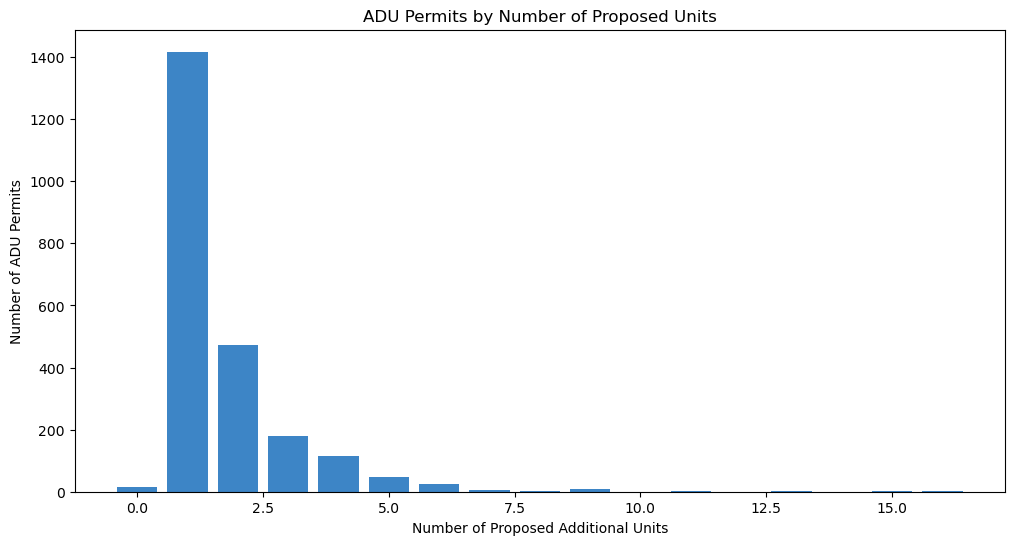

In [70]:
echo: True 
plt.figure(figsize=(12, 6))
plt.bar(unit_counts.index, unit_counts.values, color='#3d85c6ff')
plt.xlabel('Number of Proposed Additional Units')
plt.ylabel('Number of ADU Permits')
plt.title('ADU Permits by Number of Proposed Units')

In [72]:
echo: True 
#Percent of units that were part of a multi-unit permit
permits['above_threshold'] = permits['new units'] > 1
sum_by_group = permits.groupby('above_threshold')['new units'].sum().reset_index()

### Single vs. Multi-Unit Permits
In fact, this pie chart shows that nearly 2/3 of all ADU units are built with a multi-unit permit.

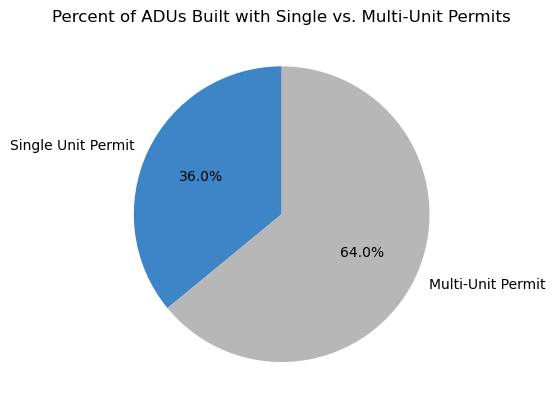

In [73]:
echo: True 
labels = ['Single Unit Permit','Multi-Unit Permit']
values = sum_by_group['new units']
customcolors = ['#3d85c6ff', '#b7b7b7ff']

plt.pie(values, labels=labels, autopct='%1.1f%%', startangle=90, colors = customcolors)
plt.title('Percent of ADUs Built with Single vs. Multi-Unit Permits')
plt.show()

In [74]:
echo: True 
#Sum of units per neighborhood
units_by_neighborhood = permits.groupby('Neighborhoods - Analysis Boundaries')['new units'].sum().reset_index()

df_sorted = units_by_neighborhood.sort_values(by='new units', ascending=True)

### ADU Permits by Neighborhood
To begin understanding the spatial distribution of ADU development, this chart shows how many units have been developed in each neighborhood.

However, if you aren't familiar with the city's neighborhoods, this isn't terribly useful.

Text(0.5, 1.0, 'ADU Units per Neighborhood')

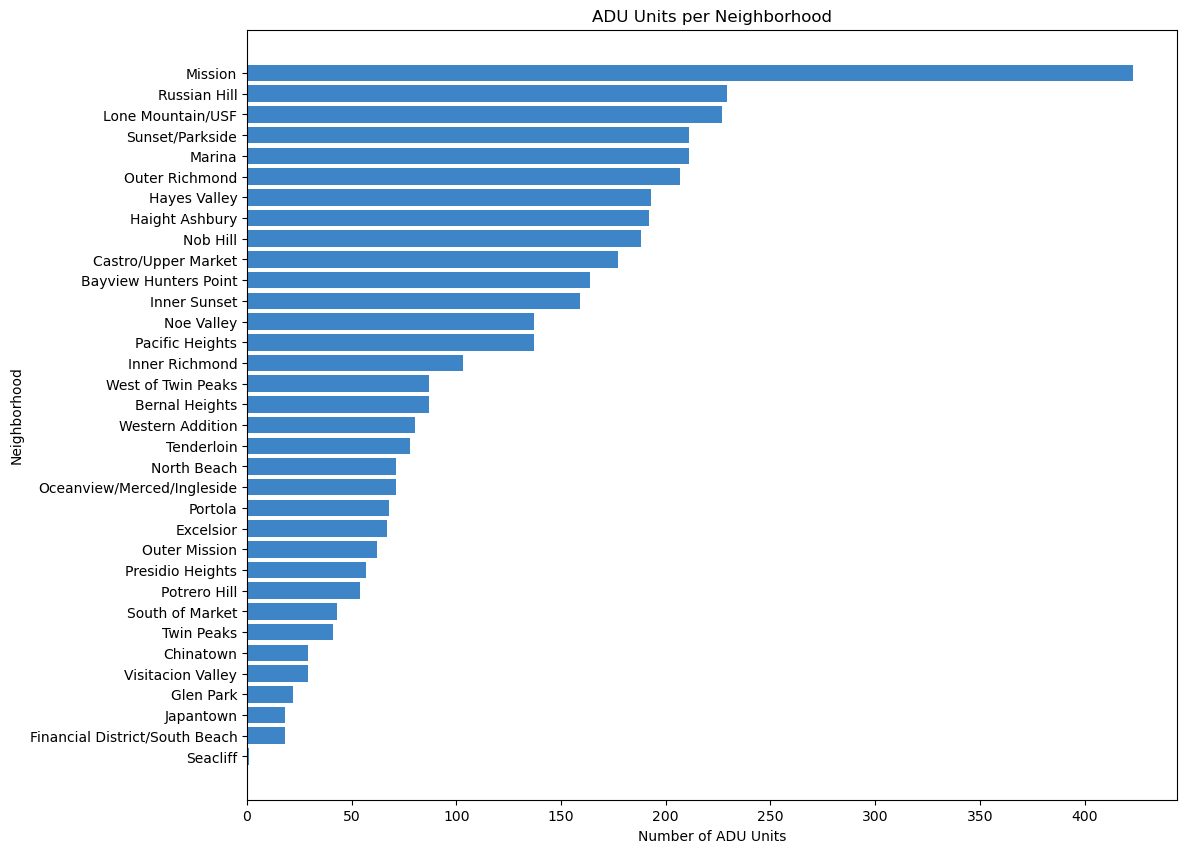

In [75]:
echo: True 
#Making bar chart for units per neighborhood
plt.figure(figsize=(12, 10))
plt.barh(df_sorted['Neighborhoods - Analysis Boundaries'], df_sorted['new units'], color='#3d85c6ff')
plt.xlabel('Number of ADU Units')
plt.ylabel('Neighborhood')
plt.title('ADU Units per Neighborhood')

## Geospatial Data Exploration

In [76]:
echo: True 
#Bring in geospatial data
permits2 = gpd.read_file("Building Permits.geojson")
neighborhoods = gpd.read_file("SF Find Neighborhoods.geojson")

In [77]:
echo: True 
#Change CRS
permits2 = permits2.to_crs(epsg=3857)
neighborhoods = neighborhoods.to_crs(epsg=3857)

In [78]:
echo: True 
permits['ColumnWithoutParentheses'] = permits['Location'].str.replace(r'[()]', '', regex=True)

In [79]:
echo: True 
permits[['point','lon', 'lat']] = permits['ColumnWithoutParentheses'].str.split(' ', expand=True)

# Convert the new columns to numeric type if needed
permits['lon'] = pd.to_numeric(permits['lon'])
permits['lat'] = pd.to_numeric(permits['lat'])

In [80]:
echo: True 
geometry = [Point(lon, lat) for lon, lat in zip(permits['lon'], permits['lat'])]
permits3 = gpd.GeoDataFrame(permits, geometry=geometry, crs='EPSG:3857')

In [81]:
echo: True 
permits3 = permits3.to_crs(neighborhoods.crs)

In [82]:
echo: True 
permits4 = permits3.dropna(subset=['new units'])

In [83]:
echo: True 
#Create groups by number of units
permits4['unit groups'] = np.where(permits4['new units'] <= 3, permits4['new units'], 4)

In [84]:
echo: True 
permits4['unit groups label'] = np.where(permits4['new units'] <= 3, permits4['new units'], '4+')

### Number of Units Per Permit
This map shows the location of ADU permits, colored by the number of units proposed. The lightest yellow indicates a single proposed unit, while the darkest red indicated four or more proposed units.

We can see that multi-unit ADU development is clustered in the city's northeast quadrant, close to downtown. The western and southern halves of the city have a higher proportion of single-unit permits, indicating that these less dense neighborhoods have more traditional "granny flats."

In [85]:
echo: True 
#map adu permots by number of new units
map_center = [permits4['lat'].mean(), permits4['lon'].mean()]
map1 = folium.Map(location=map_center, zoom_start=12, control_scale=True)

# Choose a dark tileset (e.g., "CartoDB dark_matter")
dark_tileset = "https://cartodb-basemaps-{s}.global.ssl.fastly.net/dark_all/{z}/{x}/{y}.png"

# Add the dark tileset as the basemap
folium.TileLayer(tiles=dark_tileset, attr='CartoDB Dark Matter').add_to(map1)

# Define a colormap
colormap = linear.YlOrRd_03.scale(permits4['unit groups'].min(),permits4['unit groups'].max())

permits4 = permits4.sort_values(by='new units', ascending=True)

# Add points with continuous gradient colors
for index, row in permits4.iterrows():
    folium.CircleMarker(
        location=[row['lat'], row['lon']],
        radius=1,
        color=colormap(row['unit groups']),
        fill=True,
        fill_color=colormap(row['unit groups']),
        fill_opacity=0.7,
        tooltip=f"Number of Units: {row['new units']}"
    ).add_to(map1)

# Add the colormap to the map
colormap.caption = 'Number of New Units per Permit'
colormap.add_to(map1)
# Display the map
map1

### Number of Permits per Year
In this map, the darker the dot, the more recent the permit is. We can see that the same northeast quadrant shows a high proportion of relatively early ADU development, while the western and southern halves of the city show more recent development.

In [86]:
echo: True 
#map adu permots by year
map_center = [permits4['lat'].mean(), permits4['lon'].mean()]
map2 = folium.Map(location=map_center, zoom_start=12, control_scale=True)

# Choose a dark tileset (e.g., "CartoDB dark_matter")
dark_tileset = "https://cartodb-basemaps-{s}.global.ssl.fastly.net/dark_all/{z}/{x}/{y}.png"

# Add the dark tileset as the basemap
folium.TileLayer(tiles=dark_tileset, attr='CartoDB Dark Matter').add_to(map2)

# Define a colormap
colormap2 = linear.YlOrRd_03.scale(permits4['year'].min(),permits4['year'].max())

permits4 = permits4.sort_values(by='year', ascending=False)

# Add points with continuous gradient colors
for index, row in permits4.iterrows():
    folium.CircleMarker(
        location=[row['lat'], row['lon']],
        radius=1,
        color=colormap2(row['year']),
        fill=True,
        fill_color=colormap2(row['year']),
        fill_opacity=0.7,
        tooltip=f"Permit Year: {row['year']}"
    ).add_to(map2)

# Add the colormap to the map
colormap2.caption = 'Permit Year'
colormap2.add_to(map2)
map2

Taken together, these maps show that in the years immediately following the adoption of the ADU law, developers near downtown used the law as an opportunity to convert multiple apartment building garages into units. In recent years however, more traditional ADUs - single units in less dense neighborhoods - have become more common.

## Demographic Determinants of ADU Development
In an effort to better understand what factors lead to ADU development in San Francisco, I pulled a number of Census variables to see whether any of them have a clear spatial relationship to ADU development.

The first map below shows total number of ADU Units in each of the city's Census tracts.

The second map shows the various Census variables for each tract. Use the dropdown widget to explore different variables.

Finally, the scatter plot shows the relationship between each variable and the total number of ADU units, plotted with a linear regression line. Use the dropdown widget to explore different variables.

In [87]:
echo: True 
#getting census variables
import cenpy

In [88]:
echo: True 
acs = cenpy.remote.APIConnection("ACSDT5Y2021")

In [89]:
echo: True 
variables = [
    "NAME",
    "B01003_001E", #popultaion
    "B19013A_001E", #median income
    "B25064_001E", #MEDIAN RENT
    "B25001_001E", #HOUSING UNITS
    "B08015_001E" #AGG NUMBER OF VEHICLES AVAILABLE
]

In [90]:
echo: True 
state = '06'  # California
county = '075'  # San Francisco County
tract = '*'  # Retrieve data for all census tracts within the county

In [92]:
echo: True 
census = acs.query(
    cols=variables,
    geo_unit="tract:*",
    geo_filter={"state": state, "county": county,},
)

In [93]:
echo: True 
for variable in variables:
    # Convert all variables EXCEPT for NAME
    if variable != "NAME":
        census[variable] = census[variable].astype(float)

In [94]:
echo: True 
new_tracts = gpd.read_file("Census 2020_ Tracts for San Francisco.geojson")

In [95]:
echo: True 
#Removing rows of water area and uninhabited islands
column_name = 'tractce'
value_to_remove = '980401'

# Create a boolean mask to identify rows where the variable has the specified value
mask = (new_tracts[column_name] != value_to_remove)

# Apply the mask to filter the GeoDataFrame
new_tracts = new_tracts[mask]

In [96]:
echo: True 
column_name = 'tractce'
value_to_remove = '990100'

# Create a boolean mask to identify rows where the variable has the specified value
mask = (new_tracts[column_name] != value_to_remove)

# Apply the mask to filter the GeoDataFrame
new_tracts = new_tracts[mask]

In [97]:
echo: True 
column_name = 'tractce'
value_to_remove = '990200'

# Create a boolean mask to identify rows where the variable has the specified value
mask = (new_tracts[column_name] != value_to_remove)

# Apply the mask to filter the GeoDataFrame
new_tracts = new_tracts[mask]

In [98]:
echo: True 
joinedcensus = new_tracts.merge(
    census,
    left_on=["tractce"],
    right_on=["tract"],
)

In [99]:
echo: True 
permits4 = permits4.to_crs(new_tracts.crs)

In [100]:
echo: True 
permits5 = gpd.GeoDataFrame(
    permits4, geometry=gpd.points_from_xy(permits4['lon'], permits4['lat']))

In [101]:
echo: True 
sjoin = gpd.sjoin(permits5, new_tracts, how='left', predicate='within')

In [102]:
echo: True 
#summing number of new units in each tract
uxt = sjoin.groupby('tractce')['new units'].sum().reset_index(name='Total Units')

In [103]:
echo: True 
uxt2 = pd.merge(new_tracts[['tractce']], uxt, on='tractce', how='left')

In [104]:
echo: True 
uxt2['Total Units'] = uxt2['Total Units'].fillna(0)

In [105]:
echo: True 
uxt3 = pd.merge(new_tracts, uxt2, on='tractce', how='left')

In [106]:
echo: True 
unitsmap = uxt3.hvplot(
    geo=True,
    tiles='CartoDark',
    column='Total Units',           # Column to color by
    cmap='viridis',                 # Color map
    hover_cols=['Total Units'],     # Data to show on hover
    alpha=0.7,                      # Transparency of the plots
    legend=True,                    # Display legend
    frame_width=700,                # Width of the map frame
    frame_height=500,                # Height of the map frame
    title="Total ADU Units"
)

In [107]:
echo: True 
#renaming census variables and adding population density
joinedcensus['Total Population'] = joinedcensus['B01003_001E']
joinedcensus['Median Income'] = joinedcensus['B19013A_001E']
joinedcensus['Median Rent'] = joinedcensus['B25064_001E']
joinedcensus['Total Housing Units'] = joinedcensus['B25001_001E']
joinedcensus['Total Vehicles Available'] = joinedcensus['B08015_001E']

joinedcensus['aland2'] = pd.to_numeric(joinedcensus['aland'])
joinedcensus['aland3'] = joinedcensus['aland2']*1000000
joinedcensus['Population Density (sq km)'] = joinedcensus['B01003_001E']/joinedcensus['aland3']

In [108]:
echo: True 
#removing NaNs
columns = ['Total Population','Median Income','Median Rent','Total Housing Units','Total Vehicles Available']
for col in columns:
    joinedcensus[col] = joinedcensus[col].apply(lambda x: x if x >= 0 else np.nan)

In [109]:
echo: True 
from bokeh.models import HoverTool

In [111]:
echo: True 
#create dynamic plot mapping all variables of interest
columns_to_plot = ['Total Population','Median Income','Median Rent','Total Housing Units','Total Vehicles Available','Population Density (sq km)']  # Replace with your actual column names
    
# Function to create the plot for a given column
def create_plot(column):
    hover = HoverTool(tooltips=[(column, f"@{column}")])
    return joinedcensus.hvplot(
        geo=True, 
        tiles='CartoDark', 
        column=column, 
        cmap='viridis', 
        hover_cols=column, 
        alpha=0.7, 
        legend='top_right', 
        frame_width=700, 
        frame_height=500,
        title=f"{column}"
    )

# Create a dynamic map with a dropdown for column selection
dynamic_plot = hv.DynamicMap(create_plot, kdims='Column').redim.values(Column=columns_to_plot)

In [112]:
echo: True 
joinedcensus2 = pd.merge(joinedcensus, uxt3, on='tractce', how='left')

In [113]:
echo: True 
#Making dynamic scatter plot to show relationship between each variable and the number of units
import ipywidgets as widgets
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.linear_model import LinearRegression
import numpy as np

# Assuming you already have the DataFrame 'joinedcensus' loaded in your environment
x_variables = ['Total Population', 'Median Income', 'Median Rent', 'Total Housing Units', 
               'Total Vehicles Available', 'Population Density (sq km)']
y_variable = 'Total Units'

# Function to update the plot based on the selected x variable
def update_plot(x_var):
    # Filter out rows where either x or y is NaN
    filtered_df = joinedcensus2.dropna(subset=[x_var, y_variable])

    # Clearing previous plot
    plt.clf()

    # Plotting scatter plot
    sns.scatterplot(x=filtered_df[x_var], y=filtered_df[y_variable], alpha=0.5)

    # Preparing data for Linear Regression
    x = filtered_df[x_var].values.reshape(-1, 1)
    y = filtered_df[y_variable].values

    # Linear regression
    reg = LinearRegression().fit(x, y)
    plt.plot(filtered_df[x_var], reg.predict(x), color='red')

    # Setting plot labels
    plt.xlabel(x_var)
    plt.ylabel(y_variable)
    plt.title(f"Scatter plot of {y_variable} vs {x_var} with Regression Line")
    plt.show()

# Creating dropdown widget
dropdown = widgets.Dropdown(
    options=x_variables,
    value=x_variables[0],
    description='X Variable:',
    disabled=False,
)

# Linking widget to update function
chart = widgets.interactive(update_plot, x_var=dropdown)

In [114]:
echo: True 
#New layout to be able to view maps in same space, as well as the scatter plots
layout = pn.Column(
    pn.Row(unitsmap),
    pn.Row(dynamic_plot),
    pn.Row(chart)
)

# Display the layout in the Jupyter Notebook
layout

Column
    [0] Row
        [0] HoloViews(Overlay, sizing_mode='fixed')
    [1] Row
        [0] Row
            [0] HoloViews(DynamicMap, sizing_mode='fixed')
            [1] WidgetBox(align=('end', 'start'))
                [0] Select(margin=(20, 20, 20, 20), name='Column', options=['Total Population', ...], value='Total Population', width=250)
    [2] Row
        [0] IPyWidget(interactive)

Ultimately, no clear geospatial trends emerge between the Census variables and ADU development. However, the scatterplots show us that there is a slight positive relationship between median rent and median income and ADU development, indicating that ADUs are more likely to be built in wealthier, more expensive neighborhoods. Conversely, there is a slight negative relationship between the total number of vehicles available in a Census tract and the total number of ADUs. This indicates that ADUs are more likely to be built in neighborhoods that are less car dependent.

Given that none of the included Census variables showed a strong, compelling relationship with ADU development, the next step in this work would be to widen the number of variables included and use those variables to conduct multivariate regression or machine learning to better understand and predict ADU development.